# Main Module - algo_trading_bot_extended
    # This has all the functions to generate the data and test the various models 



# All Imports

In [1]:
#Import Nasdaq Data Link (Quandl). Use "pip install nasdaq-data-link" to install library
import numpy as np
import pandas as pd
from urllib.request import urlopen
import json
from functools import reduce
import yfinance as yf
    

In [2]:
# Imports
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt

# Import StandardScaler and DateOffset
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset

# Import classification_report
from sklearn.metrics import classification_report

# Import a new classifier from SKLearn
#SCM
from sklearn import svm
#LogisticRegression
from sklearn.linear_model import LogisticRegression
#AdaBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.datasets import load_iris
from sklearn.ensemble import AdaBoostClassifier

# this helps import the dataframe from API Data Calls.ipynb, you need to run the API notebook to get this dataframe
# %store -r combined_values

In [3]:
def data_import_cleanup_function():
    #Yfinance to replace Quandl
    btc = yf.Ticker("BTC-USD")
    btc_data = btc.history(period="max")
    #btc_data = btc_data.drop
    #btc_data.head()

    #Etherium historical daily prices USD
    eth = yf.Ticker("ETH-USD")
    eth_data = eth.history(period="max")
    #eth_data.head()

    #Consumer Sentiment Data
    #Source: https://data.nasdaq.com/data/UMICH/SOC35-university-of-michigan-consumer-surveybuying-conditions-for-large-household-goods
    #consumer_sentiment = quandl.get("UMICH/SOC35")
    #consumer_sentiment.head()

    #Fear and Greed Index API call
    #source:https://alternative.me/crypto/fear-and-greed-index/
    response = urlopen("https://api.alternative.me/fng/?limit=0&date_format=us")
    json_data = response.read().decode('utf-8', 'replace')
    raw_fear_greed = json.loads(json_data)

    #Flatten json data
    fear_greed = pd.json_normalize(raw_fear_greed['data'])
    fear_greed = fear_greed.set_index("timestamp")
    fear_greed.index.names = ["Date"]
    fear_greed.index = pd.to_datetime(fear_greed.index)
    fear_greed = fear_greed.drop(columns="time_until_update")
    #fear_greed.tail()
    #fear_greed.head()

    #Combined dataframes
    combined_values_ETH = pd.concat([eth_data, fear_greed], join="inner", axis=1)
    combined_values_BTC = pd.concat([btc_data, fear_greed], join="inner", axis=1)
    #combined_values.head()

    #Testing option for merged call to streamline API calls from quandl

    #API call for merged dataset with BTC, ETH and Fear/Greed
    #merged_dataset = quandl.MergedDataset([('WIKI/AAPL', {'column_index': [11]}), ('WIKI/MSFT', {'column_index': [9,11]}), 'WIKI/TWTR'])

    #Get data for merged data set
    #data = merged_dataset.data()

    #Review data set
    #display(data)

    # Store Datafrome in memory
    # return %store combined_values
    return (combined_values_ETH, combined_values_BTC)

In [4]:
def SMAs_Function(combined_values, short_window, long_window, training_period_month_or_year="months", training_period=3):
    ### Step 1: Import the dataset into a Pandas DataFrame.
    # Filter the date index and close columns
    signals_df = combined_values.loc[:, ["Close", "value"]]

    # Use the pct_change function to generate  returns from close prices
    signals_df["Actual Returns"] = signals_df["Close"].pct_change()

    # Drop all NaN values from the DataFrame
    signals_df = signals_df.dropna()

    # Review the DataFrame
    # display(signals_df.head())
    # display(signals_df.tail())
    
    ## Step 2: Generate trading signals using short- and long-window SMA values. 
    # Set the short window and long window
    #short_window = 20
    #long_window = 100

    # Generate the fast and slow simple moving averages (4 and 100 days, respectively)
    signals_df['SMA_Fast'] = signals_df['Close'].rolling(window=short_window).mean()
    signals_df['SMA_Slow'] = signals_df['Close'].rolling(window=long_window).mean()

    signals_df = signals_df.dropna()

    # Review the DataFrame
    #display(signals_df.head())
    #display(signals_df.tail())
    
    # Initialize the new Signal column
    signals_df['Signal'] = 0.0

    # When Actual Returns are greater than or equal to 0, generate signal to buy stock long
    signals_df.loc[(signals_df['Actual Returns'] >= 0), 'Signal'] = 1

    # When Actual Returns are less than 0, generate signal to sell stock short
    signals_df.loc[(signals_df['Actual Returns'] < 0), 'Signal'] = -1

    # Review the DataFrame
    # display(signals_df.head())
    # display(signals_df.tail())
    
    # display(signals_df['Signal'].value_counts())
    
    # Calculate the strategy returns and add them to the signals_df DataFrame
    signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

    # Review the DataFrame
    # display(signals_df.head())
    # display(signals_df.tail())
    
    # Plot Strategy Returns to examine performance
    (1 + signals_df['Strategy Returns']).cumprod().plot()
    
    ### Step 3: Split the data into training and testing datasets.
    
    # Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
    X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

    # Review the DataFrame
    # display(X.head())
    
    # Create the target set selecting the Signal column and assiging it to y
    y = signals_df['Signal']

    # Review the value counts
    y.value_counts()
    
    # Select the start of the training period
    training_begin = X.index.min()

    # Display the training begin date
    # display(training_begin)
    
    # Select the ending period for the training data with an offset of 3 months
    training_end = X.index.min() + DateOffset(months=training_period)

    # Display the training end date
    # display(training_end)
    
    # Generate the X_train and y_train DataFrames
    X_train = X.loc[training_begin:training_end]
    y_train = y.loc[training_begin:training_end]

    # Review the X_train DataFrame
    X_train.head()
    
    # Generate the X_test and y_test DataFrames
    X_test = X.loc[training_end+DateOffset(hours=1):]
    y_test = y.loc[training_end+DateOffset(hours=1):]

    # Review the X_test DataFrame
    # display(X_train.head())
    
    # Scale the features DataFrames

    # Create a StandardScaler instance
    scaler = StandardScaler()

    # Apply the scaler model to fit the X-train data
    X_scaler = scaler.fit(X_train)

    # Transform the X_train and X_test DataFrames using the X_scaler
    X_train_scaled = X_scaler.transform(X_train)
    X_test_scaled = X_scaler.transform(X_test)
    
    return  X_train_scaled, X_test_scaled, X_train, X_test, y_train, y_test, signals_df, training_period

In [5]:
# inputs to the function
# classifier_name =  svm.SVC()
# classifier_name =  LogisticRegression()
# need to X_train_scaled, y_train


def classifier_function(classifier_name, X_train_scaled, X_test_scaled, X_train, X_test, y_train, y_test, signals_df, training_period):
    # Initiate the model instance
    model_instance = classifier_name
    
    # Fit the model to the data using the training data
    model = model_instance.fit(X_train_scaled, y_train)
    
    # Use the testing data to make the model predictions
    pred = model.predict(X_test_scaled)

    # Review the model's predicted values
    #pred[:10]
    
    # Review the classification report associated with the `classifier_name` model predictions. 
    # Use a classification report to evaluate the model using the predictions and testing data
    model_testing_report =  classification_report(y_test, pred, output_dict= True)
    
    output_df = pd.DataFrame(model_testing_report)
       
    # Print the classification report
    #print(svm_testing_report)
    
    # Create a predictions DataFrame that contains columns for “Predicted” values, “Actual Returns”, and “Strategy Returns”.
    # Create a new empty predictions DataFrame.
        # Create a predictions DataFrame
    new_predictions_df = pd.DataFrame(index=X_test.index)

    # Add the classifier_name model predictions to the DataFrame
    new_predictions_df['Predicted'] = pred

    # Add the actual returns to the DataFrame
    new_predictions_df['Actual Returns'] = signals_df['Actual Returns'] 
    
    # Add the strategy returns to the DataFrame
    new_predictions_df['Strategy Returns'] = (new_predictions_df['Actual Returns'] * new_predictions_df['Predicted'])

    # Review the DataFrame
    # display(new_predictions_df.head())
    # display(new_predictions_df.tail())

    # Create a cumulative return plot that shows the actual returns vs. the strategy returns. Save a PNG image of this plot. This will serve as a baseline against which to compare the effects of tuning the trading algorithm.
    # Plot the actual returns versus the strategy returns
    cumulative_return_plot = (1 + new_predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot()
    cumulative_return = (1 + new_predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod()
    
    cumulative_actual_mean = cumulative_return["Actual Returns"].iloc[-1] #.mean()
    cumulative_strategy_mean = cumulative_return["Strategy Returns"].iloc[-1] #.mean()
    
    confidence_interval_upper = (cumulative_return["Strategy Returns"].describe()["mean"]) + 1.96*(cumulative_return["Strategy Returns"].describe()["std"]) / np.sqrt(cumulative_return["Strategy Returns"].describe()["count"])
    confidence_interval_lower = (cumulative_return["Strategy Returns"].describe()["mean"]) - 1.96*(cumulative_return["Strategy Returns"].describe()["std"]) / np.sqrt(cumulative_return["Strategy Returns"].describe()["count"])

    sharpe_ratio_strategy = cumulative_return["Strategy Returns"].describe()["mean"] / (cumulative_return["Strategy Returns"].describe()["std"]) 
    sharpe_ratio_actual = cumulative_return["Actual Returns"].describe()["mean"] / (cumulative_return["Actual Returns"].describe()["std"]) 

    
    row_dict = {"Strategy_1" : {"  Short Window" : f"{short_window:.0f}", " Long Window" : f"{long_window:.0f}", 
                             " Training Period" : f"{training_period:.0f}", "Accuracy": output_df["accuracy"].iloc[0] , 
                             "Confidence Interval Upper" :  confidence_interval_upper, "Confidence Interval Lower" :  confidence_interval_lower, 
                            "Sharpe Ratio Strategy" : sharpe_ratio_strategy, "Sharpe Ratio Actual" : sharpe_ratio_actual, "Cumulative Return Actual" : cumulative_actual_mean, 
                             "Cumulative Return Strategy" :cumulative_strategy_mean }}
    
    output_classifier_function_df = pd.DataFrame(row_dict)
    return output_classifier_function_df
    #return model_testing_report, cumulative_return_plot, output_df, confidence_interval_upper, confidence_interval_lower, sharpe_ratio_strategy, sharpe_ratio_actual, cumulative_actual_mean, cumulative_strategy_mean

In [6]:
# Run Function to get the ETC and BTC Dataframes
# %run Functions
combined_values_ETH, combined_values_BTC = data_import_cleanup_function()
# display(combined_values_ETH)
# display(combined_values_BTC)

In [7]:
# User Input for Crypto to test (BTC and ETH)
def crypto_choice(BTC_or_ETH = "ETH"):
    if crypto_choice == "ETH":
        combined_values = combined_values_ETH
    else:
        combined_values = combined_values_BTC
    return combined_values

# Call Functions

In [8]:
#classifier_name =  svm.SVC()
def each_strategy(combined_values,  classifier_name, short_window, long_window, training_period_month_or_year="months", training_period=3):
    
    X_train_scaled, X_test_scaled, X_train, X_test, y_train, y_test, signals_df, training_period = SMAs_Function(combined_values, short_window, long_window, training_period_month_or_year, training_period)
    
    output_classifier_function_df = classifier_function(classifier_name, X_train_scaled, X_test_scaled, X_train, X_test, y_train, y_test, signals_df, training_period)
    #display(output_classifier_function_df)
     
    return output_classifier_function_df

In [9]:
# Call the SMA Function
# Default Values
#short_window = 7
#long_window = 60
#short_window = 14 
#long_window = 120
#short_window = 30 
#long_window = 250
#training_period_month_or_year=months, training_period=3
combined_values = crypto_choice("ETH")

#X_train_scaled, X_test_scaled, X_train, X_test, y_train, y_test, signals_df, training_period = SMAs_Function(combined_values, short_window, long_window, training_period_month_or_year="months", training_period=3)

In [10]:
# Call the Classifier function
# SVC Classifier Model
#classifier_name =  svm.SVC()
#output_classifier_function_df = classifier_function(classifier_name, X_train_scaled, X_test_scaled, X_train, X_test, y_train, y_test, signals_df, training_period)
#display(output_classifier_function_df)

In [11]:
#classifier_name =  svm.SVC()
#svc_output_classifier_function_df = each_strategy(combined_values,classifier_name, short_window = 7, long_window = 60, training_period_month_or_year="months", training_period=3)
#list_of_dfs.append(svc_output_classifier_function_df)

C:\Projects\Softwares\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Projects\Softwares\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC_Strategy_1 SVC_Strategy_2 SVC_Strategy_3  \
  Short Window                         30             14              7   
 Long Window                          250            120             60   
 Training Period                        9              9              9   
Accuracy                         0.517787       0.492119       0.488778   
Confidence Interval Lower         2.28175       0.687924       0.470184   
Confidence Interval Upper         2.48758       0.749823       0.511162   
Cumulative Return Actual           3.6318        10.6188        10.7839   
Cumulative Return Strategy         3.6318        0.15655      0.0759146   
Sharpe Ratio Actual               1.42765        1.30679        1.24493   
Sharpe Ratio Strategy             1.42765        1.34717        1.35332   

                           SVC_Strategy_4 SVC_Strategy_5 SVC_Strategy_6  \
  Short Window                         30             14              7   
 Long Window                          250            120             60   
 Training Period                        6              6              6   
Accuracy                         0.525839       0.476461       0.467954   
Confidence Interval Lower         4.80423       0.323188       0.164988   
Confidence Interval Upper         5.24352       0.354447       0.188073   
Cumulative Return Actual          8.11816        11.0216        6.36283   
Cumulative Return Strategy        8.11816      0.0603582      0.0142458   
Sharpe Ratio Actual               1.34985          1.219        1.18001   
Sharpe Ratio Strategy             1.34985         1.2105       0.832983   

                           SVC_Strategy_7 SVC_Strategy_8 SVC_Strategy_9  
  Short Window                         30             14              7  
 Long Window                          250            120             60  
 Training Period                        3              3              3  
Accuracy                         0.477787       0.523054       0.524153  
Confidence Interval Lower        0.226226        2.18889        3.73902  
Confidence Interval Upper        0.253474        2.37333        4.11468  
Cumulative Return Actual          11.6452        6.09096        6.33652  
Cumulative Return Strategy       0.030743        3.97089         7.7239  
Sharpe Ratio Actual                1.2542        1.16611        1.13952  
Sharpe Ratio Strategy            0.999027        1.33289        1.10026

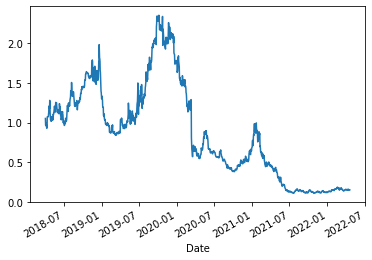

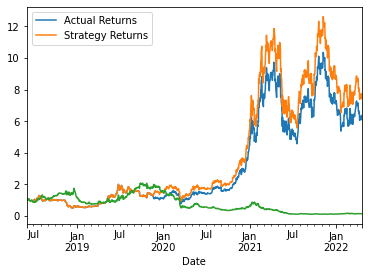

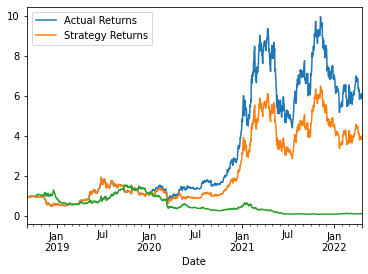

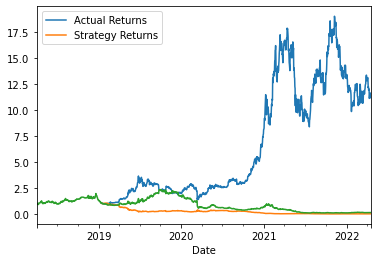

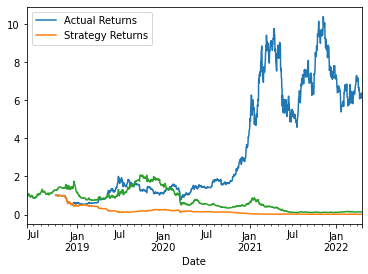

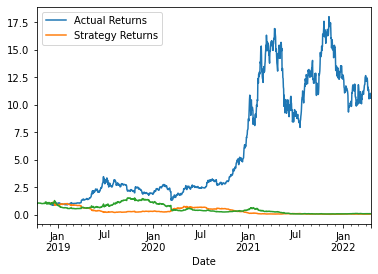

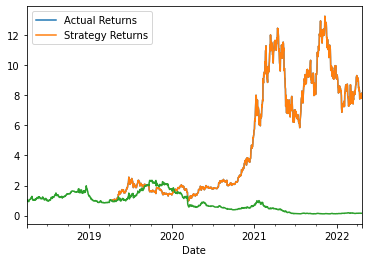

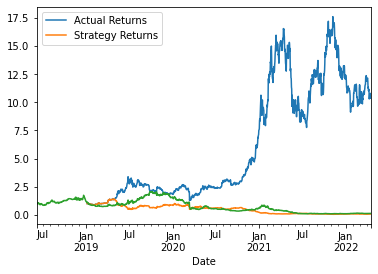

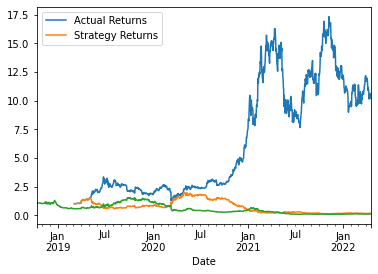

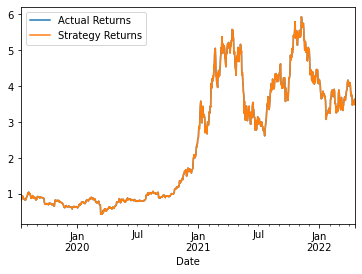

In [12]:
classifier_name =  svm.SVC()
list_of_dfs = pd.DataFrame()
short_window = 7
long_window = 60
svc_output_classifier_function_df = each_strategy(combined_values,classifier_name, short_window, long_window, training_period_month_or_year="months", training_period=3)
list_of_dfs =  pd.concat([svc_output_classifier_function_df, list_of_dfs], axis = 1)
#display(svc_output_classifier_function_df)

short_window = 14 
long_window = 120
svc_output_classifier_function_df = each_strategy(combined_values, classifier_name, short_window, long_window, training_period_month_or_year="months", training_period=3)
list_of_dfs =  pd.concat([svc_output_classifier_function_df, list_of_dfs], axis = 1)
#display(svc_output_classifier_function_df)

short_window = 30 
long_window = 250
svc_output_classifier_function_df = each_strategy(combined_values, classifier_name, short_window, long_window, training_period_month_or_year="months", training_period=3)
list_of_dfs =  pd.concat([svc_output_classifier_function_df, list_of_dfs], axis = 1)
#display(svc_output_classifier_function_df)

short_window = 7
long_window = 60
svc_output_classifier_function_df = each_strategy(combined_values,classifier_name, short_window, long_window, training_period_month_or_year="months", training_period=6)
list_of_dfs =  pd.concat([svc_output_classifier_function_df, list_of_dfs], axis = 1)
#display(svc_output_classifier_function_df)

short_window = 14 
long_window = 120
svc_output_classifier_function_df = each_strategy(combined_values, classifier_name, short_window, long_window, training_period_month_or_year="months", training_period=6)
list_of_dfs =  pd.concat([svc_output_classifier_function_df, list_of_dfs], axis = 1)
#display(svc_output_classifier_function_df)

short_window = 30 
long_window = 250
svc_output_classifier_function_df = each_strategy(combined_values, classifier_name, short_window, long_window, training_period_month_or_year="months", training_period=6)
list_of_dfs =  pd.concat([svc_output_classifier_function_df, list_of_dfs], axis = 1)
#display(svc_output_classifier_function_df)

short_window = 7
long_window = 60
svc_output_classifier_function_df = each_strategy(combined_values,classifier_name, short_window, long_window, training_period_month_or_year="months", training_period=9)
list_of_dfs =  pd.concat([svc_output_classifier_function_df, list_of_dfs], axis = 1)
#display(svc_output_classifier_function_df)

short_window = 14 
long_window = 120
svc_output_classifier_function_df = each_strategy(combined_values, classifier_name, short_window, long_window, training_period_month_or_year="months", training_period=9)
list_of_dfs =  pd.concat([svc_output_classifier_function_df, list_of_dfs], axis = 1)
#display(svc_output_classifier_function_df)

short_window = 30 
long_window = 250
svc_output_classifier_function_df = each_strategy(combined_values, classifier_name, short_window, long_window, training_period_month_or_year="months", training_period=9)
list_of_dfs =  pd.concat([svc_output_classifier_function_df, list_of_dfs], axis = 1)
#display(svc_output_classifier_function_df)


columns = ["SVC_Strategy_1", "SVC_Strategy_2","SVC_Strategy_3","SVC_Strategy_4","SVC_Strategy_5","SVC_Strategy_6","SVC_Strategy_7","SVC_Strategy_8","SVC_Strategy_9"]
list_of_dfs.columns = columns

display(list_of_dfs)

C:\Projects\Softwares\anaconda3\envs\dev\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVC_Strategy_1 SVC_Strategy_2 SVC_Strategy_3  \
  Short Window                         30             14              7   
 Long Window                          250            120             60   
 Training Period                        9              9              9   
Accuracy                          0.48419        0.49387       0.465503   
Confidence Interval Lower        0.607114        1.07389       0.213111   
Confidence Interval Upper        0.659268        1.16654       0.242323   
Cumulative Return Actual           3.6318        10.6188        10.7839   
Cumulative Return Strategy       0.165564       0.213067       0.024436   
Sharpe Ratio Actual               1.42765        1.30679        1.24493   
Sharpe Ratio Strategy             1.49602        1.40253        0.88101   

                           SVC_Strategy_4 SVC_Strategy_5 SVC_Strategy_6  \
  Short Window                         30             14              7   
 Long Window                          250            120             60   
 Training Period                        6              6              6   
Accuracy                         0.525839       0.469968       0.492664   
Confidence Interval Lower         4.80423       0.263639        0.64645   
Confidence Interval Upper         5.24352       0.292987       0.692247   
Cumulative Return Actual          8.11816        11.0216        6.36283   
Cumulative Return Strategy        8.11816      0.0372901       0.779216   
Sharpe Ratio Actual               1.34985          1.219        1.18001   
Sharpe Ratio Strategy             1.34985        1.05912        1.59211   

                           SVC_Strategy_7 SVC_Strategy_8 SVC_Strategy_9  
  Short Window                         30             14              7  
 Long Window                          250            120             60  
 Training Period                        3              3              3  
Accuracy                         0.512154       0.522298       0.485941  
Confidence Interval Lower         1.45673         1.8833       0.571092  
Confidence Interval Upper         1.58196        2.03967       0.609172  
Cumulative Return Actual          11.6452        6.09096        6.33652  
Cumulative Return Strategy        2.50274        3.39355       0.097489  
Sharpe Ratio Actual                1.2542        1.16611        1.13952  
Sharpe Ratio Strategy             1.37696        1.35184        1.63115

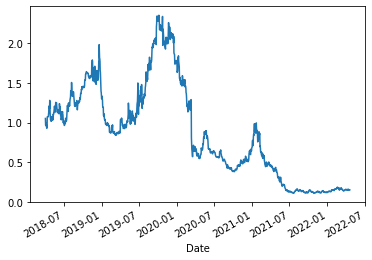

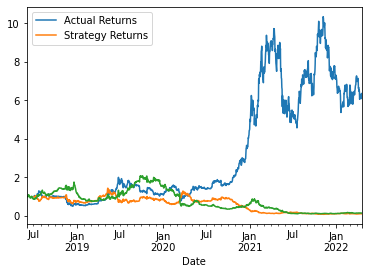

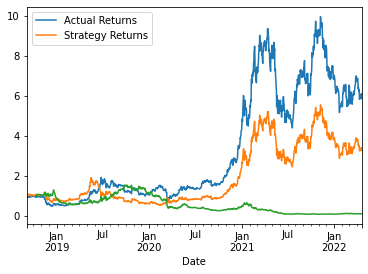

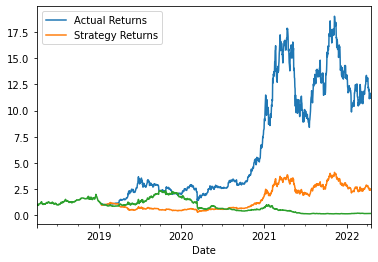

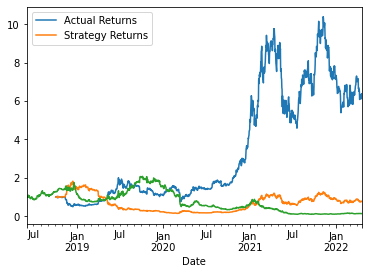

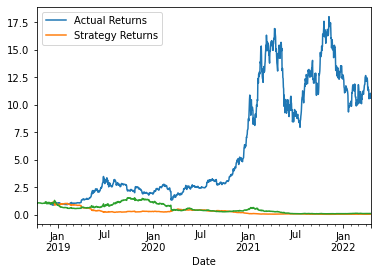

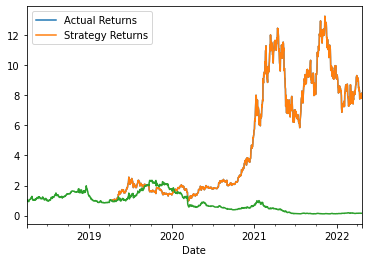

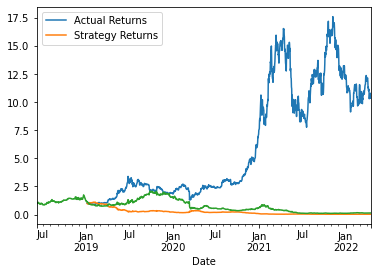

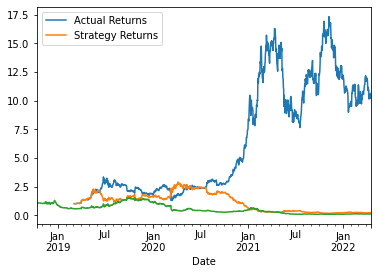

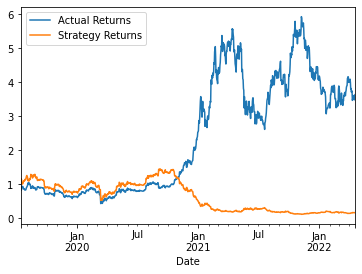

In [13]:
classifier_name =  AdaBoostClassifier()
list_of_dfs = pd.DataFrame()
short_window = 7
long_window = 60
svc_output_classifier_function_df = each_strategy(combined_values,classifier_name, short_window, long_window, training_period_month_or_year="months", training_period=3)
list_of_dfs =  pd.concat([svc_output_classifier_function_df, list_of_dfs], axis = 1)
#display(svc_output_classifier_function_df)

short_window = 14 
long_window = 120
svc_output_classifier_function_df = each_strategy(combined_values, classifier_name, short_window, long_window, training_period_month_or_year="months", training_period=3)
list_of_dfs =  pd.concat([svc_output_classifier_function_df, list_of_dfs], axis = 1)
#display(svc_output_classifier_function_df)

short_window = 30 
long_window = 250
svc_output_classifier_function_df = each_strategy(combined_values, classifier_name, short_window, long_window, training_period_month_or_year="months", training_period=3)
list_of_dfs =  pd.concat([svc_output_classifier_function_df, list_of_dfs], axis = 1)
#display(svc_output_classifier_function_df)

short_window = 7
long_window = 60
svc_output_classifier_function_df = each_strategy(combined_values,classifier_name, short_window, long_window, training_period_month_or_year="months", training_period=6)
list_of_dfs =  pd.concat([svc_output_classifier_function_df, list_of_dfs], axis = 1)
#display(svc_output_classifier_function_df)

short_window = 14 
long_window = 120
svc_output_classifier_function_df = each_strategy(combined_values, classifier_name, short_window, long_window, training_period_month_or_year="months", training_period=6)
list_of_dfs =  pd.concat([svc_output_classifier_function_df, list_of_dfs], axis = 1)
#display(svc_output_classifier_function_df)

short_window = 30 
long_window = 250
svc_output_classifier_function_df = each_strategy(combined_values, classifier_name, short_window, long_window, training_period_month_or_year="months", training_period=6)
list_of_dfs =  pd.concat([svc_output_classifier_function_df, list_of_dfs], axis = 1)
#display(svc_output_classifier_function_df)

short_window = 7
long_window = 60
svc_output_classifier_function_df = each_strategy(combined_values,classifier_name, short_window, long_window, training_period_month_or_year="months", training_period=9)
list_of_dfs =  pd.concat([svc_output_classifier_function_df, list_of_dfs], axis = 1)
#display(svc_output_classifier_function_df)

short_window = 14 
long_window = 120
svc_output_classifier_function_df = each_strategy(combined_values, classifier_name, short_window, long_window, training_period_month_or_year="months", training_period=9)
list_of_dfs =  pd.concat([svc_output_classifier_function_df, list_of_dfs], axis = 1)
#display(svc_output_classifier_function_df)

short_window = 30 
long_window = 250
svc_output_classifier_function_df = each_strategy(combined_values, classifier_name, short_window, long_window, training_period_month_or_year="months", training_period=9)
list_of_dfs =  pd.concat([svc_output_classifier_function_df, list_of_dfs], axis = 1)
#display(svc_output_classifier_function_df)


columns = ["SVC_Strategy_1", "SVC_Strategy_2","SVC_Strategy_3","SVC_Strategy_4","SVC_Strategy_5","SVC_Strategy_6","SVC_Strategy_7","SVC_Strategy_8","SVC_Strategy_9"]
list_of_dfs.columns = columns

display(list_of_dfs)

SVC_Strategy_1 SVC_Strategy_2 SVC_Strategy_3  \
  Short Window                         30             14              7   
 Long Window                          250            120             60   
 Training Period                        9              9              9   
Accuracy                         0.483202       0.470228       0.479634   
Confidence Interval Lower         0.39918       0.291157       0.259939   
Confidence Interval Upper        0.447206       0.317465       0.286394   
Cumulative Return Actual           3.6318        10.6188        10.7839   
Cumulative Return Strategy      0.0531955       0.093206       0.108354   
Sharpe Ratio Actual               1.42765        1.30679        1.24493   
Sharpe Ratio Strategy             1.08583        1.34179        1.16703   

                           SVC_Strategy_4 SVC_Strategy_5 SVC_Strategy_6  \
  Short Window                         30             14              7   
 Long Window                          250            120             60   
 Training Period                        6              6              6   
Accuracy                         0.492294       0.473214       0.484942   
Confidence Interval Lower        0.993281       0.279278       0.328884   
Confidence Interval Upper         1.09973       0.309294       0.358585   
Cumulative Return Actual          8.11816        11.0216        6.36283   
Cumulative Return Strategy       0.125915      0.0468421      0.0263542   
Sharpe Ratio Actual               1.34985          1.219        1.18001   
Sharpe Ratio Strategy             1.16038        1.09494        1.26064   

                           SVC_Strategy_7 SVC_Strategy_8 SVC_Strategy_9  
  Short Window                         30             14              7  
 Long Window                          250            120             60  
 Training Period                        3              3              3  
Accuracy                         0.472758       0.495087       0.489546  
Confidence Interval Lower        0.234438        0.66747        0.53879  
Confidence Interval Upper        0.261247       0.718389       0.577763  
Cumulative Return Actual          11.6452        6.09096        6.33652  
Cumulative Return Strategy      0.0347444       0.135549        0.48188  
Sharpe Ratio Actual                1.2542        1.16611        1.13952  
Sharpe Ratio Strategy              1.0492        1.46662        1.50776

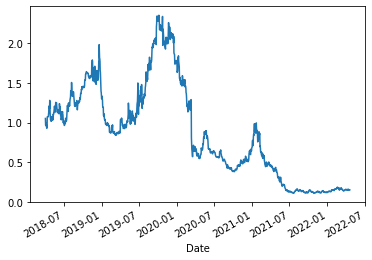

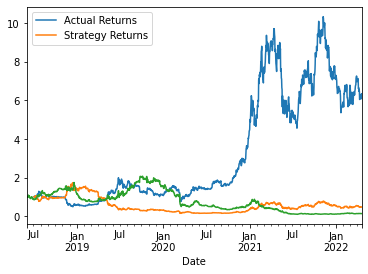

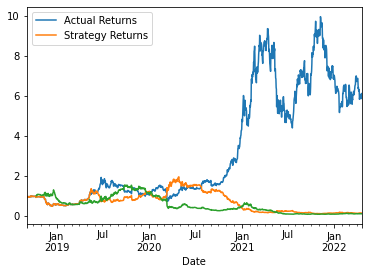

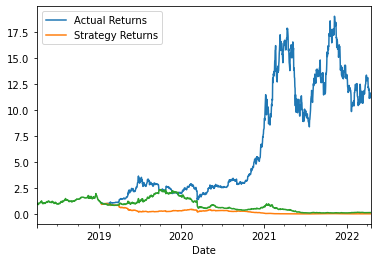

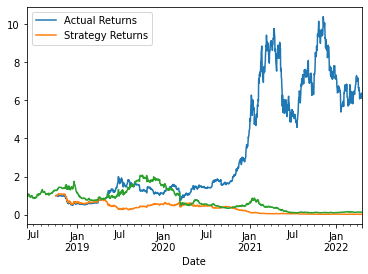

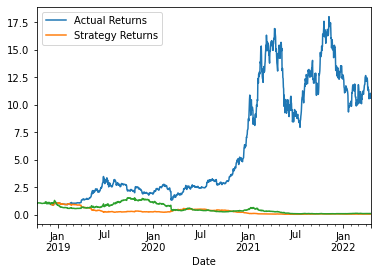

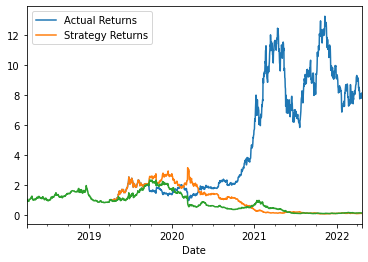

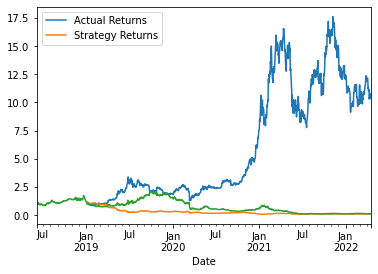

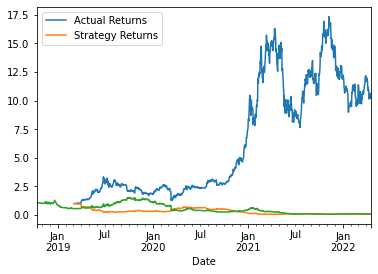

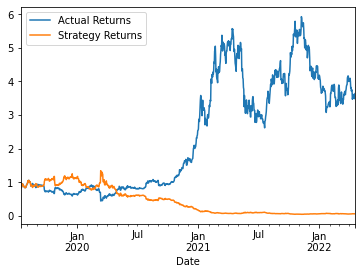

In [14]:
classifier_name =  LogisticRegression()
list_of_dfs = pd.DataFrame()
short_window = 7
long_window = 60
svc_output_classifier_function_df = each_strategy(combined_values,classifier_name, short_window, long_window, training_period_month_or_year="months", training_period=3)
list_of_dfs =  pd.concat([svc_output_classifier_function_df, list_of_dfs], axis = 1)
#display(svc_output_classifier_function_df)

short_window = 14 
long_window = 120
svc_output_classifier_function_df = each_strategy(combined_values, classifier_name, short_window, long_window, training_period_month_or_year="months", training_period=3)
list_of_dfs =  pd.concat([svc_output_classifier_function_df, list_of_dfs], axis = 1)
#display(svc_output_classifier_function_df)

short_window = 30 
long_window = 250
svc_output_classifier_function_df = each_strategy(combined_values, classifier_name, short_window, long_window, training_period_month_or_year="months", training_period=3)
list_of_dfs =  pd.concat([svc_output_classifier_function_df, list_of_dfs], axis = 1)
#display(svc_output_classifier_function_df)

short_window = 7
long_window = 60
svc_output_classifier_function_df = each_strategy(combined_values,classifier_name, short_window, long_window, training_period_month_or_year="months", training_period=6)
list_of_dfs =  pd.concat([svc_output_classifier_function_df, list_of_dfs], axis = 1)
#display(svc_output_classifier_function_df)

short_window = 14 
long_window = 120
svc_output_classifier_function_df = each_strategy(combined_values, classifier_name, short_window, long_window, training_period_month_or_year="months", training_period=6)
list_of_dfs =  pd.concat([svc_output_classifier_function_df, list_of_dfs], axis = 1)
#display(svc_output_classifier_function_df)

short_window = 30 
long_window = 250
svc_output_classifier_function_df = each_strategy(combined_values, classifier_name, short_window, long_window, training_period_month_or_year="months", training_period=6)
list_of_dfs =  pd.concat([svc_output_classifier_function_df, list_of_dfs], axis = 1)
#display(svc_output_classifier_function_df)

short_window = 7
long_window = 60
svc_output_classifier_function_df = each_strategy(combined_values,classifier_name, short_window, long_window, training_period_month_or_year="months", training_period=9)
list_of_dfs =  pd.concat([svc_output_classifier_function_df, list_of_dfs], axis = 1)
#display(svc_output_classifier_function_df)

short_window = 14 
long_window = 120
svc_output_classifier_function_df = each_strategy(combined_values, classifier_name, short_window, long_window, training_period_month_or_year="months", training_period=9)
list_of_dfs =  pd.concat([svc_output_classifier_function_df, list_of_dfs], axis = 1)
#display(svc_output_classifier_function_df)

short_window = 30 
long_window = 250
svc_output_classifier_function_df = each_strategy(combined_values, classifier_name, short_window, long_window, training_period_month_or_year="months", training_period=9)
list_of_dfs =  pd.concat([svc_output_classifier_function_df, list_of_dfs], axis = 1)
#display(svc_output_classifier_function_df)


columns = ["SVC_Strategy_1", "SVC_Strategy_2","SVC_Strategy_3","SVC_Strategy_4","SVC_Strategy_5","SVC_Strategy_6","SVC_Strategy_7","SVC_Strategy_8","SVC_Strategy_9"]
list_of_dfs.columns = columns

display(list_of_dfs)

# Original

# Test1

# Test2

# Test3

# Test4

In [15]:
#def Display_Table(short_window, long_window, training_period, max_return)
#short_window = 7
#long_window = 60
#short_window = 14 
#long_window = 120
#short_window = 30 
#long_window = 250




#ADA Boost 9*9

Return Portfolio 20%
Return Strategy 25% (+5)
Confident Interval 21-29%
Sharpe Ratio = 1.11
Accuracy ratio 50%

In [16]:
# ADA | 
